# 4 Network Analysis over time

There will be several aspects of the network analyzed over time.
1. General node and link development over the seasons of Grey's Anatomy
2. Degree and centrality development for the top characters
3. Animated network development over the seasons

In [ ]:
!pip install networkx
import networkx as nx
import pandas as pd
import json
import urllib
from sklearn import preprocessing
import re
import requests
import matplotlib.pyplot as plt
from sklearn import preprocessing
import plotly.express as px
from re import match
%matplotlib inline

You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


## 4.1 General node and link development

To analyze the network in further detail, networks for every season will be created to see the overall development of the network through the seasons. With the time component, the focus will be set on one show, the main show Grey's Anatomy as it contains most data and the community detection also revealed a good partition for separating the network by the main shows.

In [ ]:
#import the characters data and filter it to Grey's Anatomy for one focus show
df = pd.read_csv("characters.csv")
df_ga = df[df.main_universe == "Grey's Anatomy"].reset_index(drop=True)

In [ ]:
# get the links of every character to other characters for the network setup
df_ga['outlinks_clean'] = ""
df_ga['outlinks_clean'] = df_ga['outlinks_clean'].astype('object')
df_ga['character_links'] = ""
df_ga['character_links']  = df_ga['character_links'] .astype('object')

for index, row in df_ga.iterrows():
    title = row['file']
    pageid = str(row['pageid'])
    
    f = open("Character Wikipages/" + title + ".json")
    data = json.load(f)
    text = json.dumps(data)
    
    
    res = re.findall(r"\[\[.*?\]\]", text)
    res_clean = []
    for element in res:
        element = element.strip("[[").strip("]]")
        res_clean.append(element)
    
    df_ga.at[index, 'outlinks_clean'] = res_clean
        
    links_clean = []
    for element in res_clean:
        element = element.split("|")[0]
        if element in df.title.tolist():
            links_clean.append(element)
    
    single_links = list(set(links_clean))
        
    df_ga.at[index, 'character_links'] = single_links


In [ ]:
# define the functions to setup the network with the characters and the links between the characters
def set_up_network(net, character):
    # add nodes for the character with the attribute which universe 
    net.add_node(character)
    
def add_links_to_network(net, character, links_clean):
    for link in links_clean:
        if link in df_filt.title.to_list():
            net.add_edge(character, link)


# setup the character network
ga_net = nx.DiGraph()
for index, row in df_ga.iterrows():
    name = row['title']
    links_clean = row['character_links']
    
    set_up_network(ga_net, name)
    add_links_to_network(ga_net, name, links_clean)

In [ ]:
# get the positions and degree of the nodes in the network and save them in a scatter dataframe 

pos = nx.spring_layout(ga_net)

df_scatter = pd.DataFrame()
df_scatter['title'] = list(ga_net.nodes)
df_scatter['x'] = [x for x, y in pos.values()]
df_scatter['y'] = [y for x, y in pos.values()]

degrees = [degree[1] for degree in ga_net.degree]
df_scatter['degree'] = degrees

In [ ]:
# merge the characters dataframe to the scatter data with the positional information

df_scatter = pd.merge(df_scatter, df_ga.drop(columns=['pp_occurences', 'Unnamed: 0',
's19_occurences', 'main_universe', 'alias_list', 'description', 'universe_encoded']),on='title')

In [ ]:
# filter to the main characters with at least a degree of 10 to reduce the network 
# for the over time analysis 

df_scatter_main = df_scatter[df_scatter.degree > 10]

In [ ]:
# create a new dataframe with temporal information for each season and each character

new_temp = []
new_season = []
for index, row in df_scatter_main.iterrows():
    title = row['file']
    pageid = str(row['pageid'])
    
    f = open("Character Wikipages/" + title + ".json")
    data = json.load(f)
    text = json.dumps(data)
    
    
    res = re.findall(r"\[\[.*?\]\]", text)
    res_clean = []
    for element in res:
        element = element.strip("[[").strip("]]")
        res_clean.append(element)

    seasons = re.findall("(?:\'Category:GA S)(\d+)(?: Characters)", str(res_clean))
    
    for season in seasons:
        new_temp.append(row)
        new_season.append(season)

df_time = pd.DataFrame(new_temp)
df_time['season'] = new_season
df_time['season'] = df_time['season'].astype('int')
df_time = df_time.sort_values(by='season')

In [ ]:
# calculate the development of nodes and edges by getting the numbers for each season
number_of_nodes = []
number_of_edges = []
for i in range(1, 20):
    df_help = df_time[df_time.season == i]
    df_help2 = df_time[df_time.season <= i]
    ga_net_try = nx.DiGraph()
    for index, row in df_help.iterrows():
        name = row['title']
        links = row['character_links']
        links_clean = []
        for link in links:
            # only include links to other characters if they have already appeared in the show
            if link in df_help2.title.to_list():
                links_clean.append(link)
    
        set_up_network(ga_net_try, name)
        add_links_to_network(ga_net_try, name, links_clean)
    
    number_of_nodes.append(ga_net_try.number_of_nodes())
    number_of_edges.append(ga_net_try.number_of_edges())
    

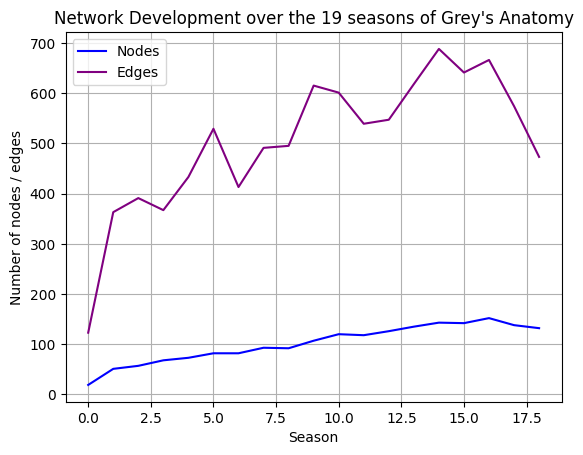

In [ ]:
# plot the development of nodes and edges
plt.title("Network Development over the 19 seasons of Grey's Anatomy")
plt.xlabel("Season")
plt.ylabel("Number of nodes / edges")
plt.xticks(range(1, 19))
plt.plot(number_of_nodes, label='Nodes', color='blue')
plt.plot(number_of_edges, label='Edges', color='purple')
plt.legend()
plt.grid()
plt.show()

## Main findings of general node and link development

The node and link development of Grey's Anatomy in the plot above shows that
* The number of nodes is steadily increasing throughout the shows with the exception of the last two seasons
* The number of edges, so connections betwenn the characters, also increases with a stronger up and down compared the the node development with the same exception in the last two seasons
* The decrease of the nodes and edges could indicate the ending of the show after 19 seasons with Ellen Pompeo as Meredith Grey leaving the show.



## 4.2 Degree and centrality development for the top characters

The analyze the characters further, we will take a look at their degree and degree centrality development through the seasons to also see if Meredith Grey is really the main character throughout the show. This analysis will be focused on the top characters of Grey's Anatomy that are highly connected and the degree threshold was set at 100 with trial and error to have enough characters to analyze but still have a clear focus.

In [ ]:
# define the top characters

top_characters = set([row['title'] for index, row in df_time.iterrows() if row['degree'] > 100])

with open('top_characters.json', 'w', encoding='utf-8') as file:
    json.dump(list(top_characters), file, ensure_ascii=False, indent=4)

In [ ]:
# calculate the position, degree and degree centrality for every character per season
df_per_season = pd.DataFrame() 
old_data = []
for i in range(1, 20):
    df_help = df_time[df_time.season == i]
    df_help2 = df_time[df_time.season <= i]
    ga_net_try = nx.DiGraph()
    for index, row in df_help.iterrows():
        name = row['title']
        links = row['character_links']
        links_clean = []
        for link in links:
            if link in df_help2.title.to_list():
                links_clean.append(link)
    
        set_up_network(ga_net_try, name)
        add_links_to_network(ga_net_try, name, links_clean)

    pos = nx.spring_layout(ga_net_try)
    degrees = ga_net_try.degree
    cent_bet = nx.betweenness_centrality(ga_net_try)
    for index, row in df_help.iterrows():
        name = row['title']
        new_x = 'x_'+str(i)
        new_y = 'y_'+str(i)
        new_degree = 'degree_'+str(i)
        new_cent = 'cent_'+str(i)

        old_data.append(row)
        df_per_season.at[index, new_x] = pos[name][0]
        df_per_season.at[index, new_y] = pos[name][1]
        df_per_season.at[index, new_degree] = degrees[name]
        df_per_season.at[index, new_cent] = cent_bet[name]

df_per_season = pd.merge(df_time, df_per_season, left_index=True, right_index=True)

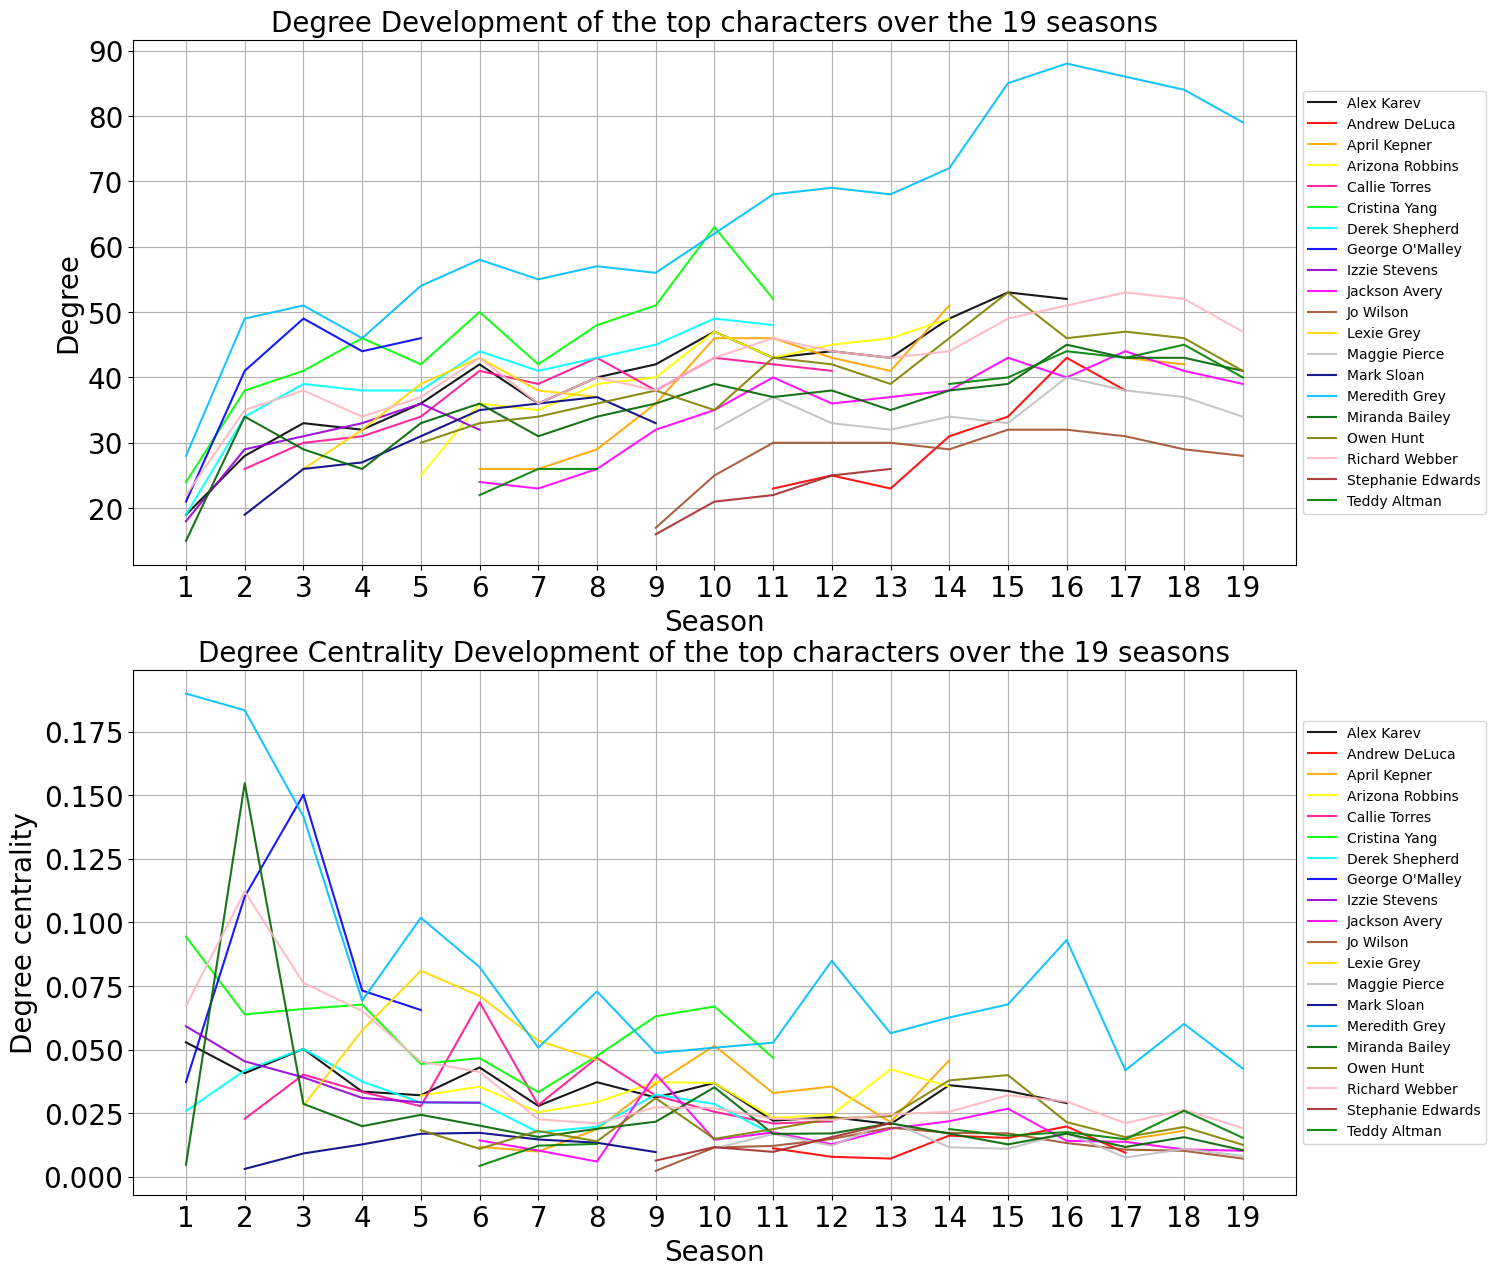

In [ ]:
# plot the degree and degree centralitydevelopment for the top characters
plt.figure(figsize=(15,15))
plt.subplot(2, 1, 1)
plt.title("Degree Development of the top characters over the 19 seasons", fontsize=20)
plt.xlabel("Season", fontsize=20)
plt.ylabel("Degree", fontsize=20)
plt.xticks(range(1, 20),fontsize=20)
plt.yticks(fontsize=20)

colors = ['black', 'red', 'orange', 'yellow', 'deeppink', 'lime', 'cyan', 'blue', 'darkviolet', 'magenta',
        'sienna', 'gold', 'silver', 'navy', 'deepskyblue', 'darkgreen', 'olive', 'lightpink', 'brown', 'green']
j = 0

for character in sorted(top_characters):
    if character in df_per_season.title.to_list():
        df_char = df_per_season[df_per_season.title == character]
        degrees_char = []
        for i in range(1, 20):
            new_degree = 'degree_'+str(i)
            degrees_char.append(df_char[new_degree].values[0])
        
        
        plt.plot(range(1, 20), degrees_char, label = character, color=colors[j], alpha=0.9)
        j += 1

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid()


plt.subplot(2, 1, 2)
plt.title("Degree Centrality Development of the top characters over the 19 seasons", fontsize=20)
plt.xlabel("Season", fontsize=20)
plt.ylabel("Degree centrality", fontsize=20)
plt.xticks(range(1, 20),fontsize=20)
plt.yticks(fontsize=20)

j = 0
for character in sorted(top_characters):
    if character in df_per_season.title.to_list():
        df_char = df_per_season[df_per_season.title == character]
        cent_char = []
        for i in range(1, 20):
            new_cent  = 'cent_'+str(i)
            cent_char.append(df_char[new_cent].values[0])
        
        
        plt.plot(range(1, 20), cent_char, label = character, color=colors[j], alpha=0.9)
        j += 1

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid()
plt.show()

## Main findings of the degree and centrality development for the top characters

The degree and degree centrality development for the top characters shows that

- Meredith Grey has the highest degree in all seasons except for season 10 where Cristina Yang's degree is the highest which could be explained by her being Meredith's person and leaving the show in that season

- Meredith's big love and husband Derek Shepherd as well as Cristina Yang show degree development at a high level after Meredith

- The degree centrality development supports these findings but also reveal that George O'Malley plays an important role in season 3 as his family is highly involved with his dad dying, him getting married and cheating on his wife with his best friend

## 4.3 Animated network development

To get a better overview of the network, we decided to also animate the development for the most central and also the top characters of Grey's Anatomy.

In [ ]:
# define the color of the node based on the degree to identify the top characters
df_time['color_degree'] = ['red' if degree > 100 else 'black' for degree in df_time.degree] 

In [ ]:
# filter the data to the most central characters
df_time = df_time[(df_time.x >= -0.1) & (df_time.x <= 0.1) & (df_time.y >= -0.1) & (df_time.y <= 0.1)]

In [ ]:
# plot animation of the scatter plot for the Grey's Anatomy network development
fig_time = px.scatter(df_time, x="x" , y="y", hover_name="title", text='title', 
                        color="color_degree", opacity=0.5, size='degree', animation_frame='season',
                         color_discrete_sequence=["red", "black"])

fig_time.layout.update(title_text="Development of the Grey's Anatomy Network for the main characters",
                       title_font_size=20, showlegend=False)
fig_time.layout.updatemenus[0].buttons[0].args[1]["frame"]["duration"] = 2000

fig_time.update_layout(yaxis_range=[-0.1,0.1])
fig_time.update_layout(xaxis_range=[-0.1,0.1])
fig_time.show()

In [ ]:
# create a dataframe with position and degree by seasons
df_per_season_new = pd.DataFrame() 
old_data = []
for i in range(1, 20):
    df_help = df_time[df_time.season == i]
    df_help2 = df_time[df_time.season <= i]
    ga_net_try = nx.DiGraph()
    for index, row in df_help.iterrows():
        name = row['title']
        links = row['character_links']
        links_clean = []
        for link in links:
            if link in df_help2.title.to_list():
                links_clean.append(link)
    
        set_up_network(ga_net_try, name)
        add_links_to_network(ga_net_try, name, links_clean)

    pos = nx.spring_layout(ga_net_try)
    degrees = ga_net_try.degree
    cent_bet = nx.betweenness_centrality(ga_net_try)
    for index, row in df_help.iterrows():
        if row['season'] == i:
            name = row['title']
            old_data.append(row)
            df_per_season_new.at[index, 'x_season'] = pos[name][0]
            df_per_season_new.at[index, 'y_season'] = pos[name][1]
            df_per_season_new.at[index, 'degree_season'] = degrees[name]
            df_per_season_new.at[index, 'cent_season'] = cent_bet[name]

df_per_season_new = pd.merge(df_time, df_per_season_new, left_index=True, right_index=True)

df_per_season_new = df_per_season_new[df_per_season_new.degree>100]

In [ ]:
# animate the positions and degrees per season
fig_time_season = px.scatter(df_per_season_new, x="x_season" , y="y_season", hover_name="title", 
                             text='title', color="color_degree", opacity=0.5, size='degree_season',
                             animation_frame='season', color_discrete_sequence=["red", "black"])

fig_time_season.layout.update(title_text="Development of the Grey's Anatomy Network for the top characters",
                            title_font_size=15, showlegend=False)

fig_time_season.layout.updatemenus[0].buttons[0].args[1]["frame"]["duration"] = 2000

fig_time_season.update_layout(autosize=False, width=1100, height=600)
fig_time_season.update_layout(xaxis_range=[-0.35,0.35])
fig_time_season.update_layout(yaxis_range=[-0.4,0.35])
fig_time_season.show()

## Main findings of the animated network development

The animated network is useful to visualize the development and some interesting findings are the following.
* The couples of the show being close for example Meredith Grey and Derek Shepherd, Jackson Avery and April Kepner or Owen Hunt and Teddy Oltman.
* With Meredith and Derek being the main couple of the show, they are not as close as expected, Meredith is closer to her stepsister Lexie even though they have a rough start of their relationship getting to know each other as adults after Lexie's mom dies.
* However, it is difficult to analyze with many characters and many changes happening.



<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=6c50234c-0fc5-40eb-b0ef-2d1cda57d893' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>